# Model Training
## Summary

### Setup Dependencies

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
import pickle

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [7]:
df = pd.read_csv('data/analytical_base_table.csv')

### Split your dataset

In [10]:
y = df.status

X = df.drop('status', axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234, stratify=df.status)

print(len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


### Build model pipelines

In [15]:
pipeline_dict = {
    'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)),
    'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

### Declare Hyperparameters to Tune

In [16]:
pipeline_dict['l1'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logis

In [17]:
l1_hyperparameters = { 'logisticregression__C': np.linspace(1e-3, 1e3, 10)}
l2_hyperparameters = { 'logisticregression__C': np.linspace(1e-3, 1e3, 10)}

In [18]:
rf_hyperparameters = { 
    'randomforestclassifier__n_estimators':[100,200],
    'randomforestclassifier__max_features':['auto', 'sqrt', 0.33]
}

In [19]:
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100,200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1,3,5]
}

In [20]:
hyperparameter_dict = {
    'l1': l1_hyperparameters,
    'l2': l2_hyperparameters,
    'rf': rf_hyperparameters, 
    'gb': gb_hyperparameters
}

### Fit and Tune Models with Cross-Validation

In [21]:
fitted_models = {}

for name, pipeline in pipeline_dict.items():
    model = GridSearchCV(pipeline, hyperparameter_dict[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted')

l1 has been fitted
l2 has been fitted
rf has been fitted
gb has been fitted


### Evaluate Metrics

In [22]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.8493868846632309
l2 0.8493868846632309
rf 0.9794739648125111
gb 0.9752976719388662


### Area und ROC curve
Area under ROC curve is the most reliable metric for classification tasks

In [23]:
from sklearn.metrics import roc_curve, auc

In [24]:
prediction = fitted_models['l1'].predict(X_test)

prediction[:10]


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [25]:
# display confusion matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, prediction))

[[1969  172]
 [ 221  452]]


In [27]:
# predict probability for each class
prediction = fitted_models['l1'].predict_proba(X_test)

prediction = [p[1] for p in prediction]

prediction[:10]

[0.030570068795554312,
 0.004441966451284315,
 0.007296299059829627,
 0.08809785247584849,
 0.07115093691981708,
 0.4816093551967909,
 0.1260487635624961,
 0.6152946554247725,
 0.7266592780305593,
 0.1370359611945163]

In [28]:
# calculate the ROC
fpr, tpr, thresholds = roc_curve(y_test, prediction)

In [29]:
pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds}).tail(10)

,FPR,TPR,Thresholds
532,0.759925,0.994056,0.009627
533,0.784680,0.994056,0.008120
534,0.784680,0.995542,0.008076
535,0.910322,0.995542,0.001962
536,0.910322,0.997028,0.001950
537,0.932742,0.997028,0.001393
538,0.932742,0.998514,0.001388
539,0.949089,0.998514,0.001051
540,0.949089,1.000000,0.001040
541,1.000000,1.000000,0.000027


In [35]:
def plot_roc_curve(fpr,tpr):
    # plot ROC curve
    figure = plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')

    plt.plot(fpr, tpr, label='l1')
    plt.legend(loc='lower right')

    plt.plot([0,1],[0,1], 'k--')

    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.ylabel('True Position Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [36]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, prediction)

print(auc(fpr,tpr))

0.9015430014581235


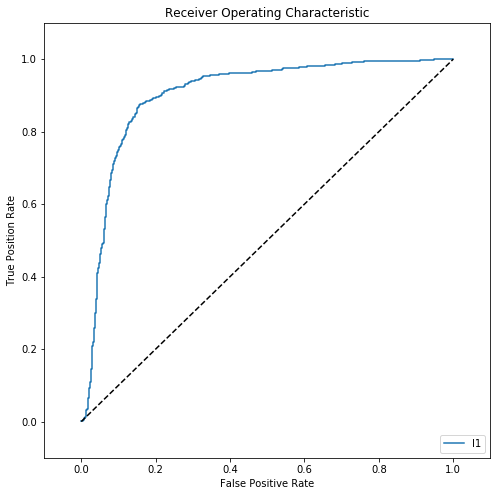

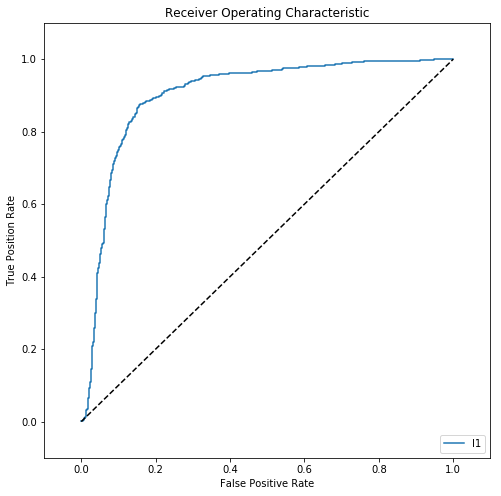

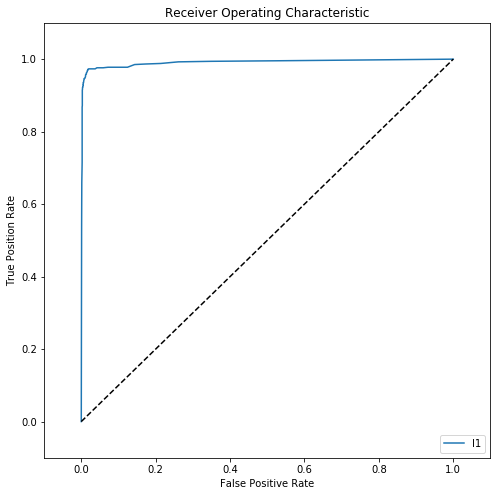

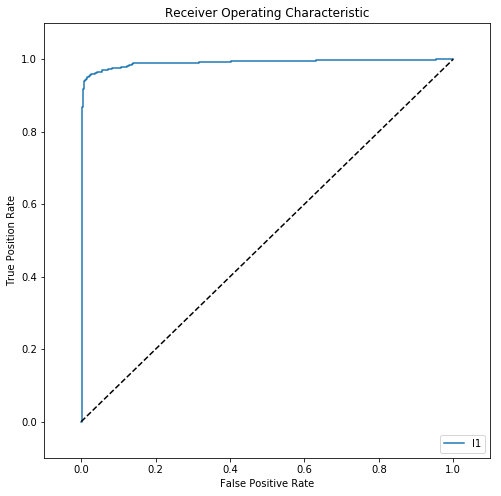

In [37]:
for name, model in fitted_models.items():
    prediction = model.predict_proba(X_test)
    prediction = [p[1] for p in prediction]
    
    fpr,tpr, thresholds = roc_curve(y_test, prediction)
    plot_roc_curve(fpr,tpr)
    

In [38]:
# save winning pipeline
with open('final_model.pk1', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)